# Выделение актуальных проблем из текстов обращений на сайте московской мэрии

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from random import randint
import copy
import re
import tqdm
import re 
import geopandas as gpd
import operator
from matplotlib import pyplot
import matplotlib.ticker as ticker
import statistics
import warnings
warnings.filterwarnings('ignore')

# 1. Обработка текстов. Определение тематики обращения.

***В ходе выполнения задания, было выявлено, что в большинстве обращений очень много шума. Слова написаны с орфографическими ошибками, присутствуют мусорные символы, опечатки. Всё это мешает nlp моделям выделять тематику обращения. Была предпринята попытка предварительной очистки текста обращений, но она слабо решала проблему. В итоге принято решение не тратить время и использовать регулярные выражения для определения тематики обращения, сэкономив при этом время обработки, и улучшив качество определения темы. Так же это даёт возможность тонкой настройки выделения тем и подтем***

In [2]:
# Загрузка сообщений портала "mos.ru"
fname = 'Mosru_dump_all_pages_abridged.txt'
with open(fname, 'r', encoding= 'utf8') as f:
    all_lines= f.readlines()

In [3]:
def get_year(all_lines):
    """ Функция выделения года из обращения """
    year = (int(re.findall('\d\d\d\d',  all_lines.split("', '")[4]  )[0]))
    return (year)

In [4]:
# Функция выделяет название района 
def get_area(area_raw): 
    """ Функция определения названия района """
    area_raw = area_raw.replace('ё', 'е')
    # Запросы регулярки для поиска района:
    reqs_get_area = ['(?<=управы )(.*)(?= района)', '(?<=района)(.*)(?=города)', '(?<=управы района )(.*)(?=)',
                    '(?<=главы управы )(.*)(?=)', '(?<=Глава управы )(.*)(?=)', '(?<=ГБУ "Жилищник района )(.*)(?=")',
                    '(?<=ГБУ "Жилищник )(.*)(?=района")','(?<=«Жилищник района)(.*)(?=»)','(?<=района ")(.*)(?=")',
                    '(?<=ГБУ "Жилищник Жулебино района )(.*)(?=")', '(?<=управы, Управа )(.*)(?=)'] 
    # Выделяем районы
    areas, area = [], ''
    for req in reqs_get_area:          # по каждому запросу в запросах поиска района
        areas.append(re.findall(
            req, area_raw))            # добавляем найденный район по запросу 
    for area_iter in areas:            # Все полученные районы с запроса 
        if area_iter != []:            # PS: посмотреть, может несколько районов в одном запросе находит
            area = area_iter           # Если нашли по регулярке район, прерываем  
            break                
            
    if area:                            # Если определили район
        area = area[0].strip()          # Обрежем лишние пробелы
        # Переведем в именительный падеж:
        re.findall(req, area)
        a = re.findall('(?<=).*?(?=ого)', area)  # ищем НЕ имен.падеж
        if a and a[0] =='Тверск':                # Переводим в именительный:
            a = a[0]+'ой'
        elif a and a[0] =='Басманн':
            a = a[0]+'ый'
        elif a and a[0] =='Проспект Вернадск':
            a = a[0]+'ого'
        elif a:
            a = a[0]+'ий' 
        else:
            a = area                             # Оставляем, если уже в имен.падеже
        return (a)
    else:
        return('')                      # Если район не определен, возвр.пустую строку

In [5]:
def get_street(street_raw):
    """ Функция определения улицы из обращения """
    # Искомый паттерн:
    pattern = '((?<=по адресу)(.*)(?=д.))|(?<=по адресу)(.*)(?=вл.)|'+\
    '(?<=по адресу)(.*)(?=с.)|(?<=по адресу)(.*)(?!=[(д.)(с.)(вл.)])' 
    street = re.findall(pattern, street_raw )
    
    if street:
        street = [t for t in street[0] if len(t)>0][0].strip()
        return(street)
    else:
        return('')

In [6]:
# Сопоставление названия улицы и района. 
# Район извлекается из наименования ответчика по обращению, улица из проблемы докладчика
street_to_area = dict({})                  # создаём словарь под 'улица:район'
streets = [None for street in all_lines]

for j,message in enumerate(all_lines):
    street_raw = message.split("', '")[0]  # Часть с обозначеной проблемой и улицой
    street = get_street(street_raw)        # Пытаемся найти улицу
    area_raw = message.split("', '")[3]    # Ответчик
    area = get_area(area_raw)              # Пытаемся найти район
    if street and area:                    # Если нашли район и улицу
        street_to_area[street] = area      # Добавляем в словать улицу с районом
    if street:
        streets[j] = street                # Если нашли только улицу, добавляем в список улицу

In [7]:
def clean_text(phrase):
    """Удаляем шумы мы из текста обращения"""
    # удаляем англ буквы, слеши
    phrase = re.sub('\/|[a-zA-Z]', '', phrase)  
    # УДАЛЯЕМ СООБЩЕНИЯ В СКОБОЧКАХ
    phrase = re.sub(r'\([^\)]+\)', '', phrase)
    #--------------------
    # удаляем BACKSLASH:
    phrase = re.sub('\\\\', ' ', phrase)    
    # Удялем фразы приветствия и прочие бесполезные слова:
    phrase = re.sub('Добрый день|Добрый вечер|Доброе утро|Прошу|Здравствуйте|Приветствую|Пожалуйста',' ',
                    phrase, flags=re.I) 
     # Удаляем обозначения номеров
    phrase = re.sub('[№#]{1,}', '', phrase) 
    phrase = re.sub('[&;]{1,}', ' ', phrase)
    # Удаляем буквы одинокостоящие
    phrase = re.sub(' [мо] ', '', phrase, flags=re.I) 
    # удаляем цифру с буквой (адрес, номер дома...) пер.6|д. 12
    phrase = re.sub(
        r' [а-яА-ЯёЁ]{1,3}[.]\d{1,}| [а-яА-ЯёЁ]{1,3}[.] \d{1,}|[д] \d{1,}| (дом) \d{1,}', '', phrase) 
    phrase = re.sub('\d{1,}[а-яА-Я]{1,}|\d{1,}\-\w{1,}|\w{1,}\d{1,}|\w{1,}\d{1,}\w{1,}', '', phrase)  
    # Удаляем подряд идущие знаки. Заменяем пробелом
    phrase = re.sub('[!,.:)(=?]{2,}', ' ', phrase)
    # Удаляем одинокостоящие знаки препинания
    phrase = re.sub(' [,.?!] ', ' ', phrase)
    # Удаляем оставшиеся цифры
    phrase = re.sub('\d', '', phrase) 
    return (phrase)

In [8]:
def find_topic(text):
    """Ищем ключевые фразы, определяем топик. Каких фраз топика больше, такой и топик"""
    topics_prob = dict([('Мусор',0),('Стройка',0),('Реклама',0),('Граффити',0),('Пешеходы',0),('Освещение',0),
                        ('Торговля',0), ('Дороги',0), ('Автомобили',0)]) 
    # проблемы мусора, поваленных деревьев
    rubbish = re.findall(
        r'\bмусор|\bдерев|Захл[ао]м|\bхлам|свалк[\w]|\bмеш\w{1,2}|Грунт|\bкуча|уборка|\bурн[\w]', text, flags=re.I)
    topics_prob['Мусор'] = len(rubbish)
    # проблема незаконной рекламы (рекламные щиты, плакаты)
    advertising = re.findall(
        r'\bреклам|\bщит|\bвывеск|\bвывесок|плакат|штендер|конструкци|\bбанер|\bбаннер|902-ПП|'+ \
        '902 пп|902пп|\bафиша|медиаэкран|Объявлен\w{2}|винилов\w{2} полот|табло|бегущ\w{1,2} строк',
        text, flags=re.I)
    topics_prob['Реклама'] = len(advertising)
    # проблемы связанные со стройкой и её окончанием
    construction = re.findall(r'\bстро[йи]|бетонны[\w] блок|Бетонн\w{1,2} плит|ремонтны[\w] работ|\bРаскоп',
                              text, flags=re.I)
    topics_prob['Стройка'] = len(construction)
    # проблема граффити и прочих надписей/рисунков на стенах
    graffiti = re.findall(r'надпис|граффити|графити| каракул', text, flags=re.I)
    topics_prob['Граффити'] = len(graffiti)
    # проблемы пешеходов и инвалидов
    footpassenger = re.findall(r'\bпешеход|\bплитк|\bтактильн|\bпандус|\bогражден|тротуар|\bлестни[а-я]+|\bперил',
                               text, flags=re.I)
    topics_prob['Пешеходы'] = len(footpassenger)
    # проблемы освещения
    lighting = re.findall(r'свет|\bосвещ[а-я]+|\bтемн|\bламп', text, flags=re.I)
    topics_prob['Освещение'] = len(lighting)    
     # проблемы незаконной торговли
    trading = re.findall(r'\bторг[а-я]+|\bкиоск|\bНТО\b|\bпродажа|продают\b', text, flags=re.I)
    topics_prob['Торговля'] = len(trading)  
     # проблемы с дорожным покрытием
    road = re.findall(r'дорожн|\bяма\b|\bямы\b|\bям\b|\bасфальт\b|\bразметк', text, flags=re.I)
    topics_prob['Дороги'] = len(road)
    # проблемы с брошеными авто, неправильная парковка
    auto = re.findall(r'автомобил[\w]|\bпарковк|парковочн|машина|\bавто|'+ \
                      'грузовик|транспортн\w{2} средств|колес[\w] спущен|без номер', text, flags=re.I)
    topics_prob['Автомобили'] = len(auto)    
    
    # Если есть какие-то найденные ключ.слова, возвращаем топик с макс.значением
    if max(topics_prob.values()) != 0:
        return(max(topics_prob.items(), key=operator.itemgetter(1))[0])
    else:
        return('')

In [9]:
def test():
    """Функция для проверки определения топика"""
    start = 2000
    for ind in range(len(all_lines[start:2500])):        # С отслеживанием прогресса запускаем итерации по txt  
        street = streets[ind+start]                      # Улица с обращения
        area = street_to_area.get(street, None)          # Определяем район по улице
        if street and area:                              # Если и улица и район определены
            text = all_lines[ind+start].split("', '")[1] # Текст обращения
            print (text)
            year = get_year(all_lines[ind+start])        # Вычисляем год обращения
            topic = find_topic(text)
            print (topic)
            print (70*'_')

In [10]:
topic_per_area = dict([(area,[]) for area in street_to_area.values()]) # создаём словарь район - топик. 
times_per_area = dict([(area,[]) for area in street_to_area.values()]) # Создаём словарь район - год обращения по топику
success_cnt = 0                                      # счётчик успешных обнаружений темы

ind_empty = []                                       # список с номерами сообщ. с неопределенными топиками 
for ind in tqdm.tqdm(range(len(all_lines))):         # С отслеживанием прогресса запускаем итерации по txt  
    street = streets[ind]                            # Улица с обращения
    area = street_to_area.get(street, None)          # Определяем район по улице
    if street and area:                              # Если и улица и район определены
        text = all_lines[ind].split("', '")[1]       # Текст обращения
        year = get_year(all_lines[ind])              # Вычисляем год обращения
        #text = clean_text(text)                      # Очищаем текст
        topic = find_topic(text)                     # Определяем топик
        
        # Если определили топик, заносим топик обращения и дату в словари:
        if topic!='':
            topic_per_area[area].append(topic)
            times_per_area[area].append(year)
            success_cnt+=1               # счётчик успешного определения топика
        else:
            ind_empty.append(ind)        # добавляем номер сообщ. как неопределенный топик
                
print('В {:2.2f}% сообщений удалось определить тему'.format(100*success_cnt/len(all_lines)))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 90176/90176 [00:12<00:00, 7254.24it/s]

В 82.21% сообщений удалось определить тему


In [11]:
def show_empty_topics():
    """Функция для просмотра обращений, где тема не выявлена алгоритмом"""
    for ind in ind_empty:
        print (all_lines[ind].split("', '")[1])

In [12]:
#show_empty_topics()

## 1.1 Количество обращений граждан

***Посмотрим, сколько обращений было за каждый год:***

In [13]:
years = []
for ind in range(len(all_lines)):
    years.append(get_year(all_lines[ind]))
# Получаем уникальные элементы спика лет:
years_unique = set(years)
years_unique = list(years_unique)
years_unique.sort()
# Cловарь с кол-вом обращений по годам:
count_treatment = dict({})
for year in years_unique:
    count_treatment[year] = (years.count(year))

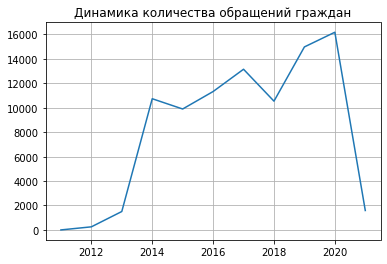

In [14]:
plt.plot(list(count_treatment.keys()), list(count_treatment.values()))
plt.title('Динамика количества обращений граждан')
plt.grid()

***Видно, что обращения начались с 2014 года, возможно раньше не была готова база для этого, либо люди не знали о такой возможности. В 2021м году обращений мало, т.к год только начался.***

***Так, с 2014 года прослеживается динамика увеличения количества обращений. Возможно, это говорит о том, что обращения граждан выслушиваются, и по ним принимаются меры.***

# 2. Определение проблемных тем каждого района. Визуализация по карте Москвы.

#### Расшифровка каждой темы:
- Мусор - всё что касается захламления территории: неубранные ветки деревьев, грязь, переполненные урны, свалки мусора в неустановленных для этого местах.
- Реклама - незаконная реклама, неправильно установленные баннеры, сомнительные объявления на стенах и пр.
- Стройка - всё, что связано со строительной деятельностью: шум на стройке, оставленная разруха после каких-либо работ.
- Пешеходы - проблемы, связанные с перемещением пешеходов: разрушенные дорожки, разбитая тактильная плитка, сломанные перилла или лестницы.
- Автомобили - брошенные автомобили, неправильная парковка.
- Дороги - ямы на дорогах.
- Освещение - отсутствие какого-либо освещения.
- Торговля - всё то, что касается незаконной торговли, торговли с несоблюдением каких-либо требований и норм.
- Граффити - разрисованные стены, надписи на заборах и пр.

## 2.1 Концентрация проблем по районам

***Считаем количество топиков в каждом районе по каждой теме:***

In [15]:
topics_prob = dict([('Мусор',0),('Стройка',0),('Реклама',0),('Граффити',0),('Пешеходы',0),('Освещение',0),
                    ('Торговля',0), ('Дороги',0), ('Автомобили',0)])  # ('Подъезды',0),
area_topic_count = dict({})      # словарь с количеством каждой темы в каждом районе 
area_topic_prob = dict({})       # словарь вероятности отнесения обращения к каждой теме по районам

for area in topic_per_area.keys():
    if not area in area_topic_count.keys(): 
        area_topic_count[area] = []         # если район не занесен в словарь - заносим 
        area_topic_prob[area] = []
    # Считаем кол-во обращеней по каждой теме в районе
    for topic in topics_prob.keys():
        area_topic_count[area].append(topic_per_area[area].count(topic))
    # Считаем процент каждой темы темы в районе
    for count in area_topic_count[area]:
        area_topic_prob[area].append(count / sum(area_topic_count[area]))

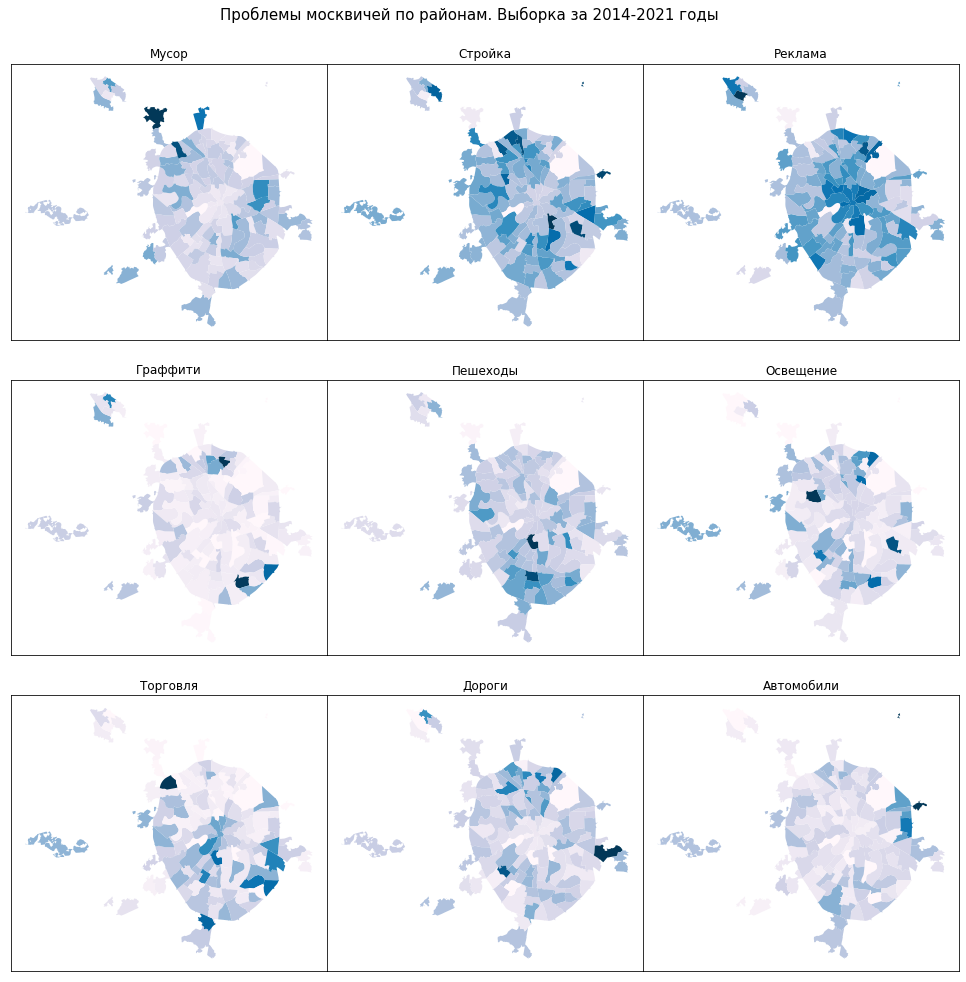

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(17, 17))   
plt.subplots_adjust(wspace=0, hspace=0.08)            # расстояние между axes
num = 0

plt.suptitle('Проблемы москвичей по районам. Выборка за 2014-2021 годы', y=0.92, fontsize=15)
for num_topic, topic_name in enumerate(topics_prob.keys()):
    # Загрузка карты МО
    mo_gdf = gpd.read_file('mo-shape/mo.shp')
    # сопоставление названий районов из текстов mos.ru и из карты районов
    mo_gdf['NAME_NORM'] = mo_gdf['NAME'].apply(lambda x: x.lower().replace('ё','е')) 
    mo_gdf['topic_importance'] = 0.0
    for j in mo_gdf.index:
        area_stemmed = mo_gdf.iloc[j]['NAME_NORM'] 
        for area in area_topic_prob.keys():
            if area_stemmed in area.lower():
                mo_gdf.loc[j,'topic_importance']= float(area_topic_prob[area][num_topic])   
                break
    mo_gdf = mo_gdf.loc[mo_gdf['TYPE_MO'] == 'Муниципальный округ']  # только муницип.округ печатаем  
    
    # Печатаем маленькие карты с темами проблемы
    mo_gdf.plot(ax=axes[num // 3, num % 3],
                column = 'topic_importance', linewidth=1.5, cmap='PuBu', legend= False)
    axes[num // 3, num % 3].title.set_text(topic_name)   # название проблемы в тайтле
    
    # Убираем маркировку осей от геопандаса
    axes[num // 3, num % 3].xaxis.set_major_locator(ticker.NullLocator())
    axes[num // 3, num % 3].yaxis.set_major_locator(ticker.NullLocator())
    num += 1

***Видно, что в центральном округе больше всего москвичей волнует проблема незаконной рекламы. Брошенные автомобили и граффити, как правило, наблюдаются вдали от центра. Проблемы, связанные со стройкой и незаконной торговлей наблюдается разрознено по всей территории Москвы.***

## 2.2 Округа с самой большой концентрацией каждой проблемы

***Поскольку выборки проблем совсем не равнозначны: есть более глобальные проблемы, такие как "мусор", и менее, такие как "граффити", попробуем посмотреть, в каких округах в наибольшей степени сосредоточена каждая проблема***

In [17]:
probs_mean_district = []
for num_topic, topic_name in enumerate(topics_prob.keys()):          # по всем топикам
    prob_mean_district = []
    # Загрузка карты МО
    mo_gdf = gpd.read_file('mo-shape/mo.shp')
    mo_gdf = mo_gdf.loc[mo_gdf['TYPE_MO'] == 'Муниципальный округ']  # только муницип.округ  
    mo_gdf.reset_index(inplace = True)
    # Сопоставление названий районов из текстов mos.ru и из карты районов
    mo_gdf['NAME_NORM'] = mo_gdf['NAME'].apply(lambda x: x.lower().replace('ё','е')) 
    for district in mo_gdf['ABBREV_AO'].unique():  # по всем округам
        prob_district = []                         # вероятность проблемы в округе
        for j in mo_gdf.index:
            area_stemmed = mo_gdf.iloc[j]['NAME_NORM']
            distinct_area = mo_gdf.iloc[j]['ABBREV_AO']
            for area in area_topic_prob.keys():
                # если зона есть на карте и она в текущем районе
                if area_stemmed in area.lower() and distinct_area == district:
                    try:
                        prob_district.append(float(area_topic_prob[area][num_topic]))
                    except Exception as e:
                        pass
        try:
            prob_mean_district.append(statistics.mean(prob_district)) # средняя вероятность топика в округе
        except Exception as e:
            prob_mean_district.append(0)
    probs_mean_district.append(prob_mean_district)      # добавляем вероятности всех топиков в округе 

district_topic_max_ind = []                                   # Список индексов проблем с номером округа
for i, topic in enumerate(topics_prob):                       # по всем округам
    # Регион с наивысшей плотностью проблемы:
    district_topic_max_ind.append(probs_mean_district[i].index(max(probs_mean_district[i])))

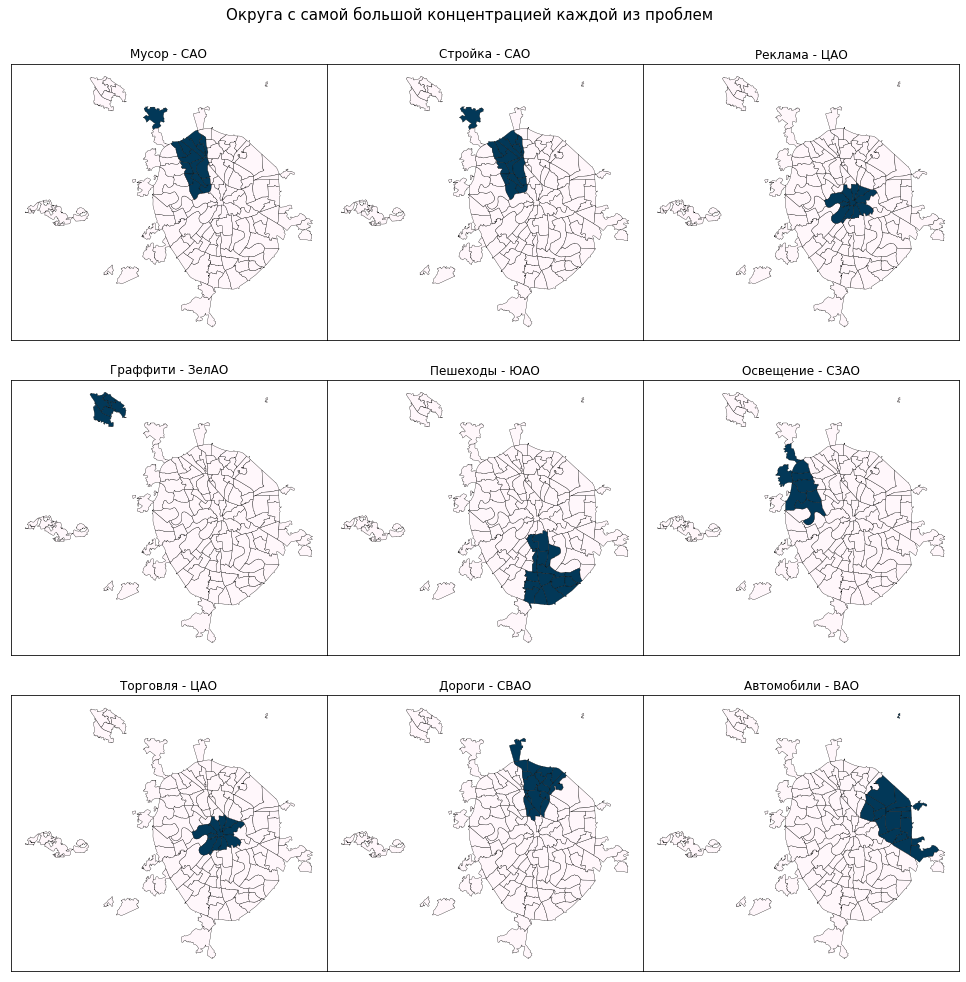

In [18]:
# Заполняем самый запущенный округ по каждой проблеме:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(17, 17))   
plt.subplots_adjust(wspace=0, hspace=0.08)                       # расстояние между axes
plt.suptitle(f'Округа с самой большой концентрацией каждой из проблем', y=0.92, fontsize=15)
num = 0
mo_gdf = gpd.read_file('mo-shape/mo.shp')
mo_gdf = mo_gdf.loc[mo_gdf['TYPE_MO'] == 'Муниципальный округ']  # только муницип.округ  
mo_gdf.reset_index(inplace = True)                               # сбрасываем индексы

for q in range(len(district_topic_max_ind)):
    mo_gdf['topic_importance'] = 0.0
    for i in range(len(mo_gdf)):
        # Если регион совпадает с самым запущенным по проблеме, ставим "1" в "topic_importance":
        if mo_gdf['ABBREV_AO'][i] == mo_gdf['ABBREV_AO'].unique()[district_topic_max_ind[q]]:
            mo_gdf['topic_importance'][i] = 1
            
        # Печатаем маленькие карты с темами проблемы
    mo_gdf.plot(ax=axes[num // 3, num % 3],column = 'topic_importance', linewidth=0.3, cmap='PuBu', legend= False,
               edgecolor='black')
    # Топик проблемы и округ в заголовок:
    axes[num // 3, num % 3].title.set_text(list(topics_prob.keys())[q]+' - '+
                                           mo_gdf['ABBREV_AO'].unique()[district_topic_max_ind[q]]) 
    
    # Убираем маркировку осей от геопандаса
    axes[num // 3, num % 3].xaxis.set_major_locator(ticker.NullLocator())
    axes[num // 3, num % 3].yaxis.set_major_locator(ticker.NullLocator())
    num += 1

## 2.3 Динамика концентрации проблем по районам

***Далее посмотрим, как изменялась доля каждой из тем в районах по годам:***

In [19]:
area_topic_prob_list, area_topic_count_list = [], []
for year in [2014,2015,2016,2017,2018,2019,2020]:
    topics_prob = dict([('Мусор',0),('Стройка',0),('Реклама',0),('Граффити',0),('Пешеходы',0),('Освещение',0),
                        ('Торговля',0), ('Дороги',0), ('Автомобили',0)])
    area_topic_count = dict({})      # словарь с количеством каждой темы в каждом районе 
    area_topic_prob = dict({})       # словарь вероятности отнесения обращения к каждой теме по районам

    for area in topic_per_area.keys():
        if not area in area_topic_count.keys(): 
            area_topic_count[area] = []         # если район не занесен в словарь - заносим 
            area_topic_prob[area] = []

        # Формируем topic_per_area_year[area] по интересующему нас году:
        topic_per_area_year = dict([(area,[]) for area in street_to_area.values()])
        for number, topic in enumerate(topic_per_area[area]):
            if times_per_area[area][number] == year:
                topic_per_area_year[area].append(topic)     # добавляем топик в словарь за тек.год

        # Считаем кол-во обращеней по каждой теме в районе
        for number, topic in enumerate(topics_prob.keys()):
            area_topic_count[area].append(topic_per_area_year[area].count(topic))
        # Считаем процент каждой темы темы в районе
        for count in area_topic_count[area]:
            try:
                area_topic_prob[area].append(count / sum(area_topic_count[area]))
            except Exception as e:
                pass
    # Заносим словари с вер.топика по каждому году в список
    area_topic_prob_list.append(area_topic_prob)
    area_topic_count_list.append(area_topic_count)

## 2.3.1 Отображаем проблему картинкой каждый год

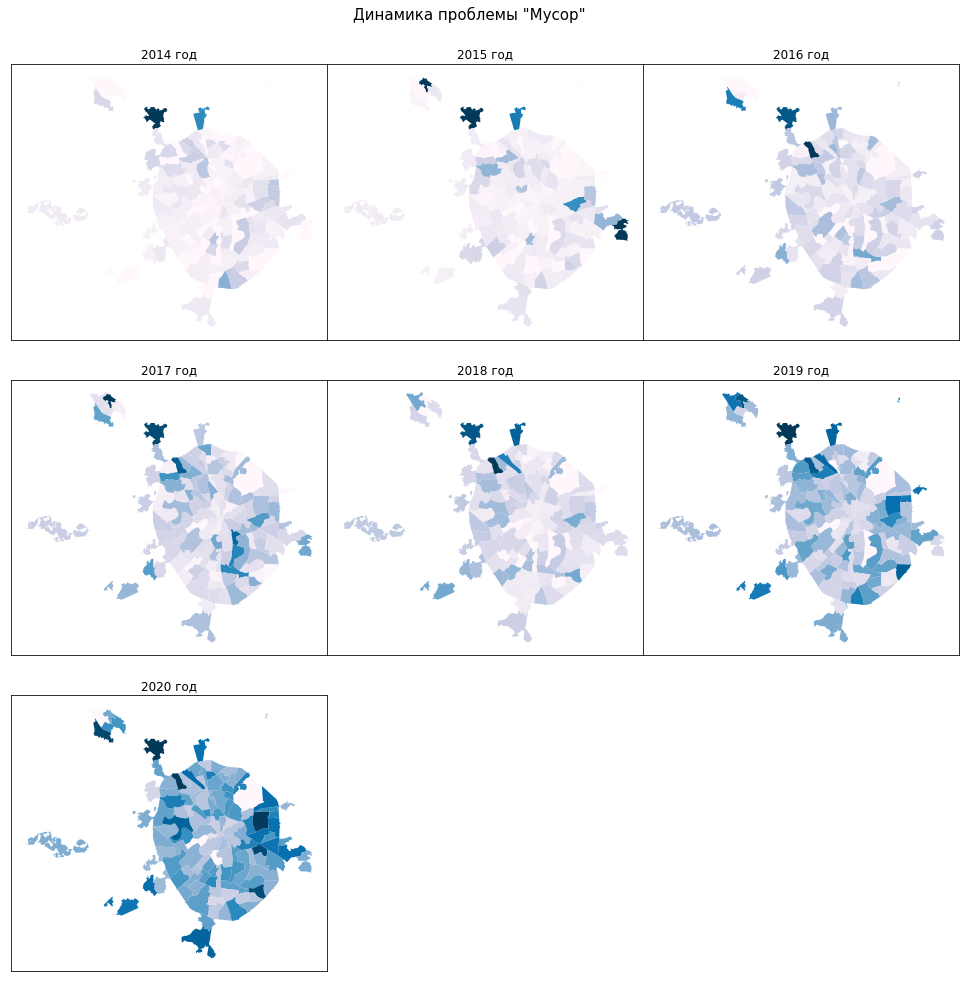

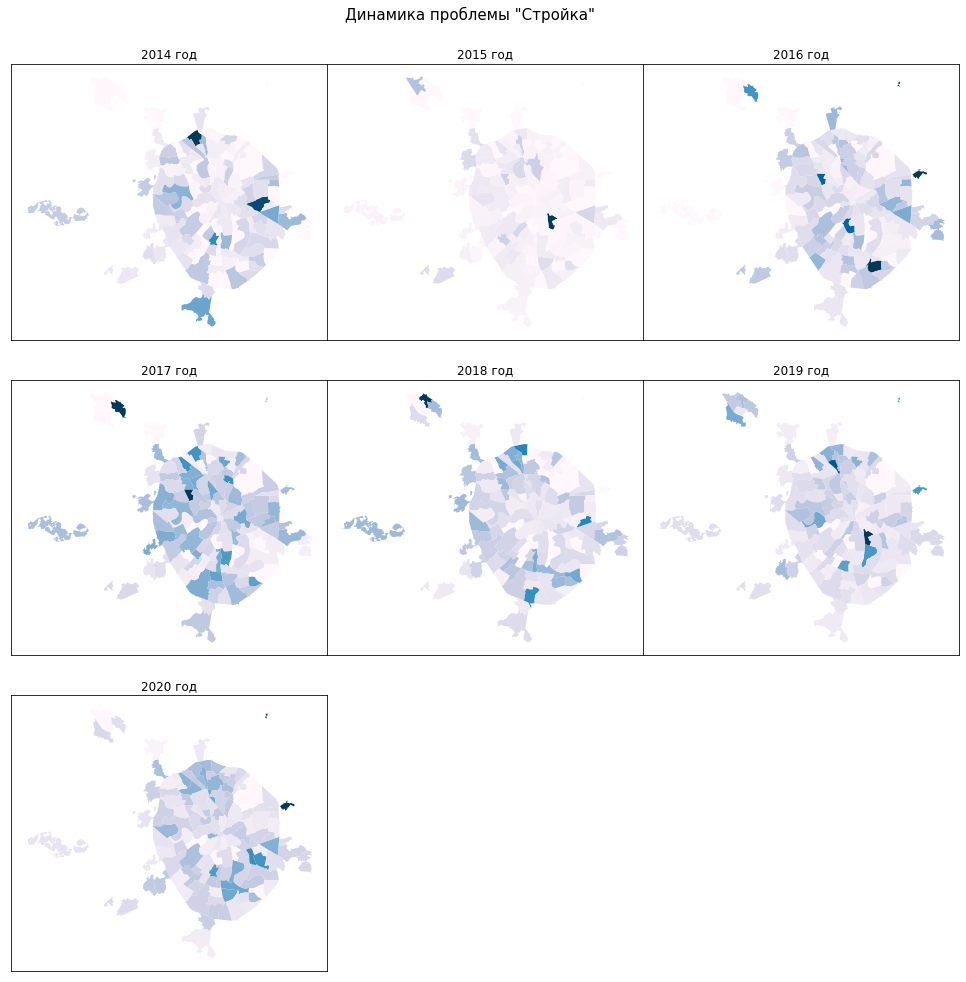

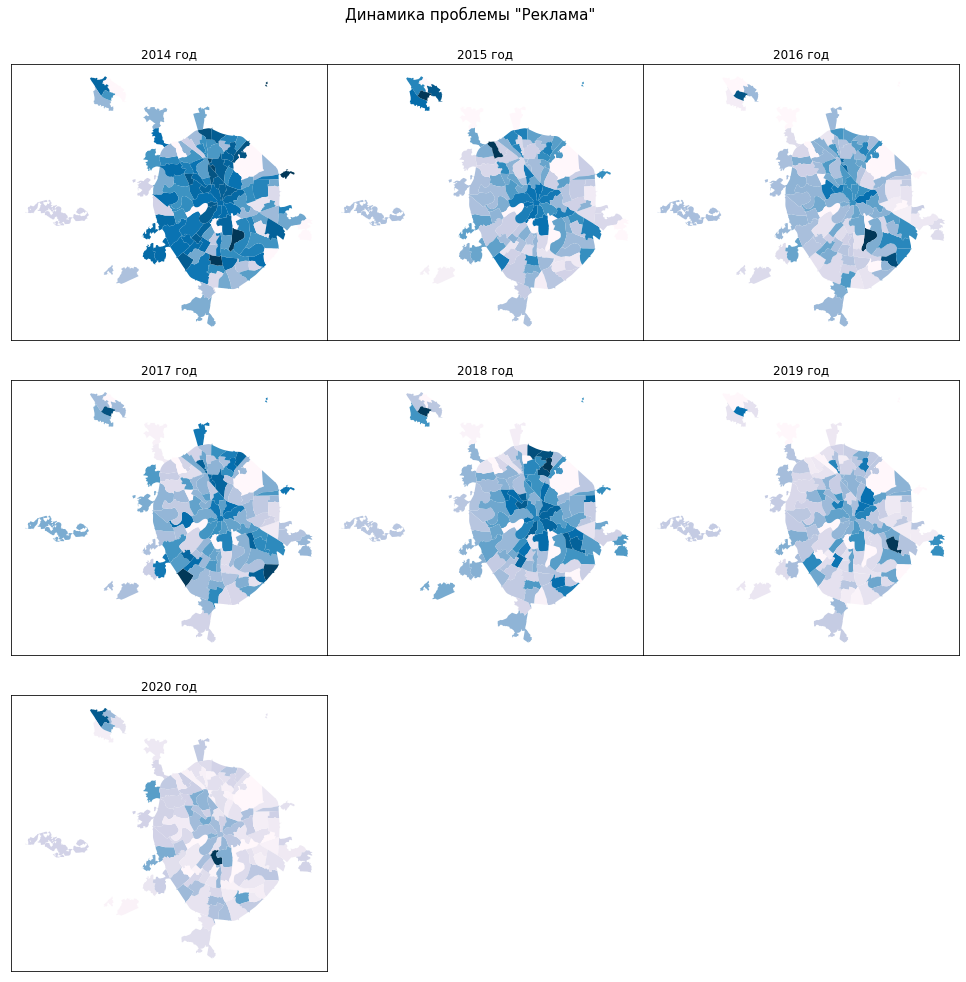

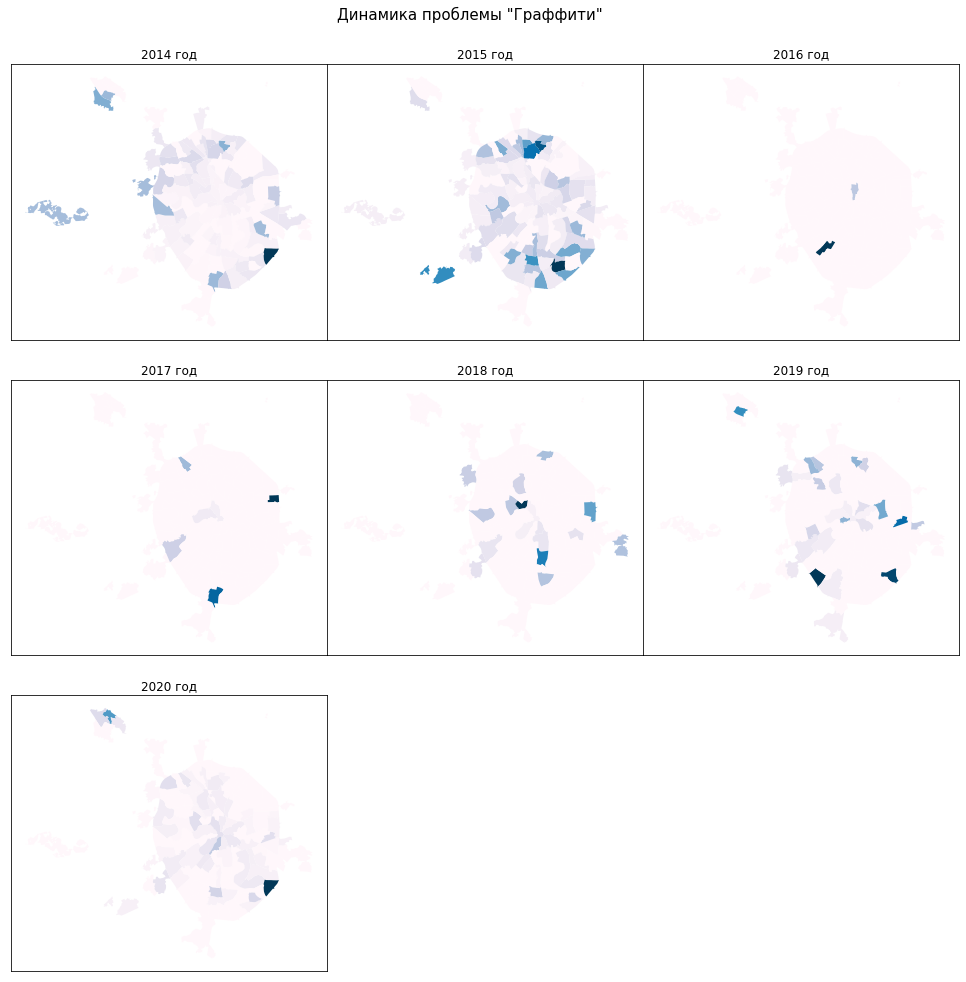

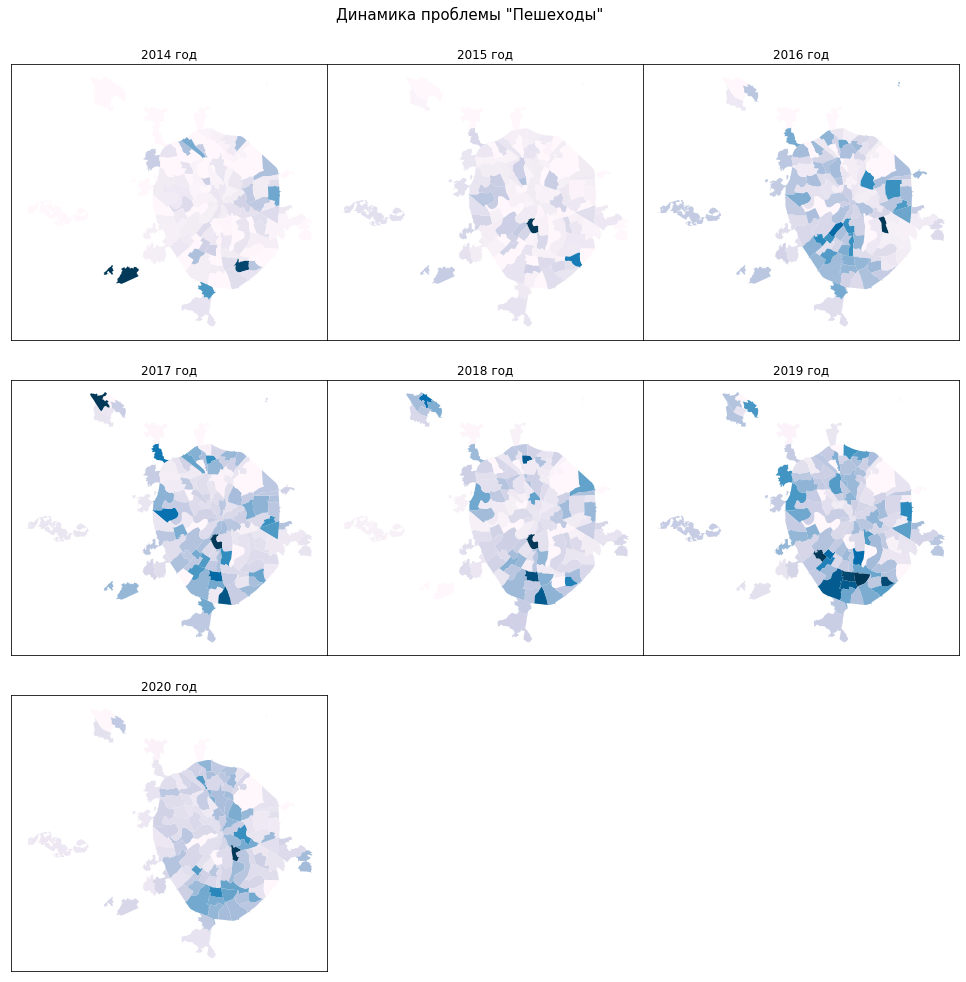

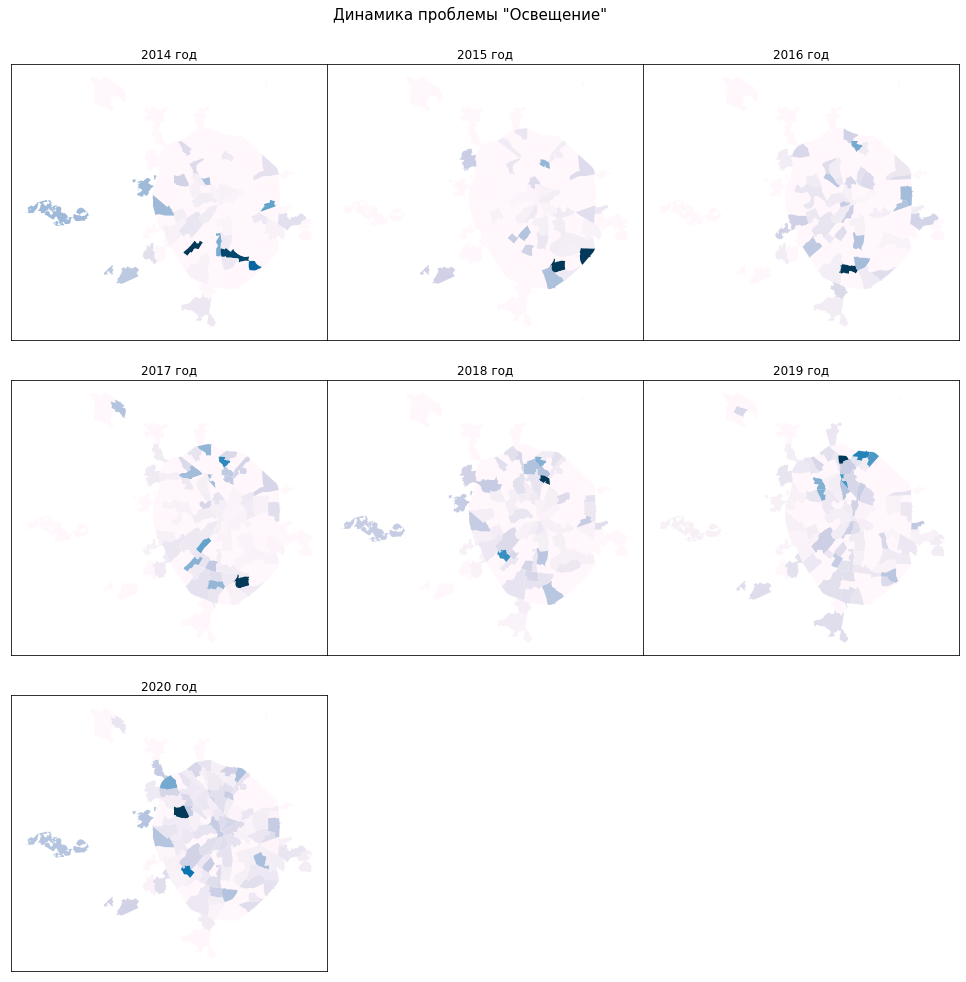

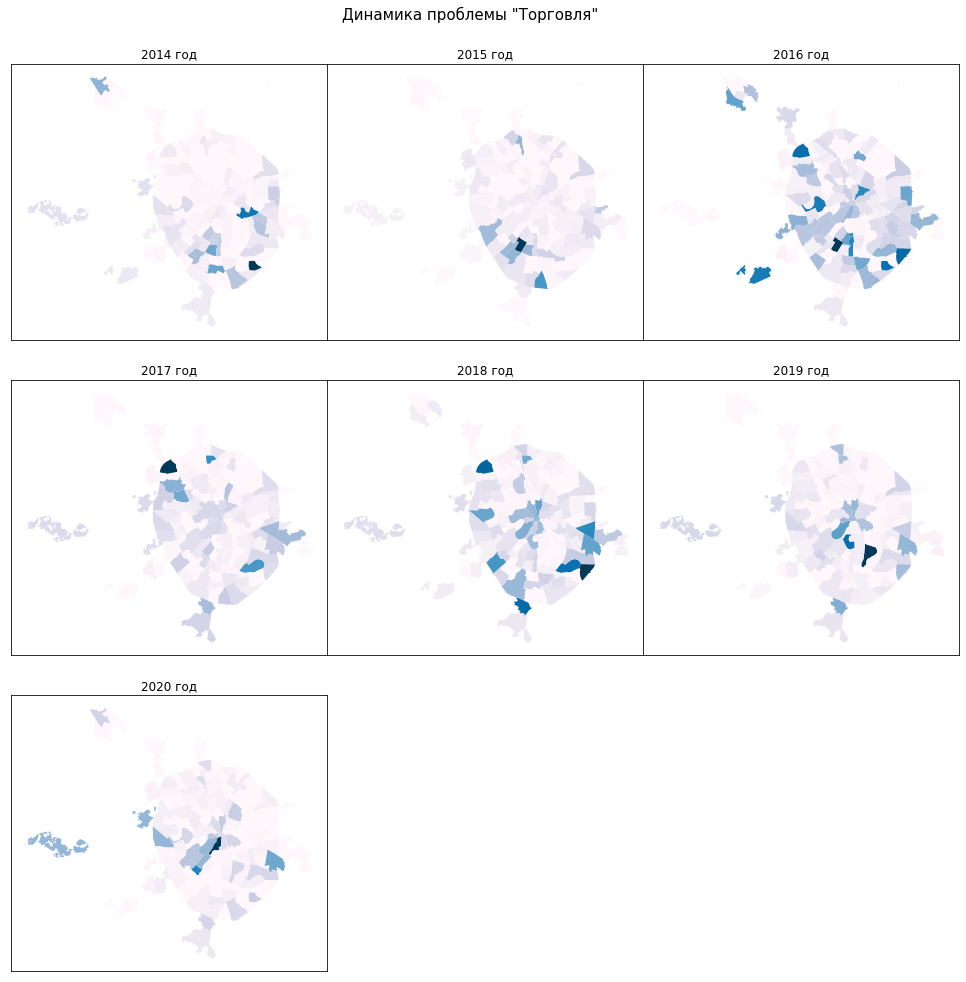

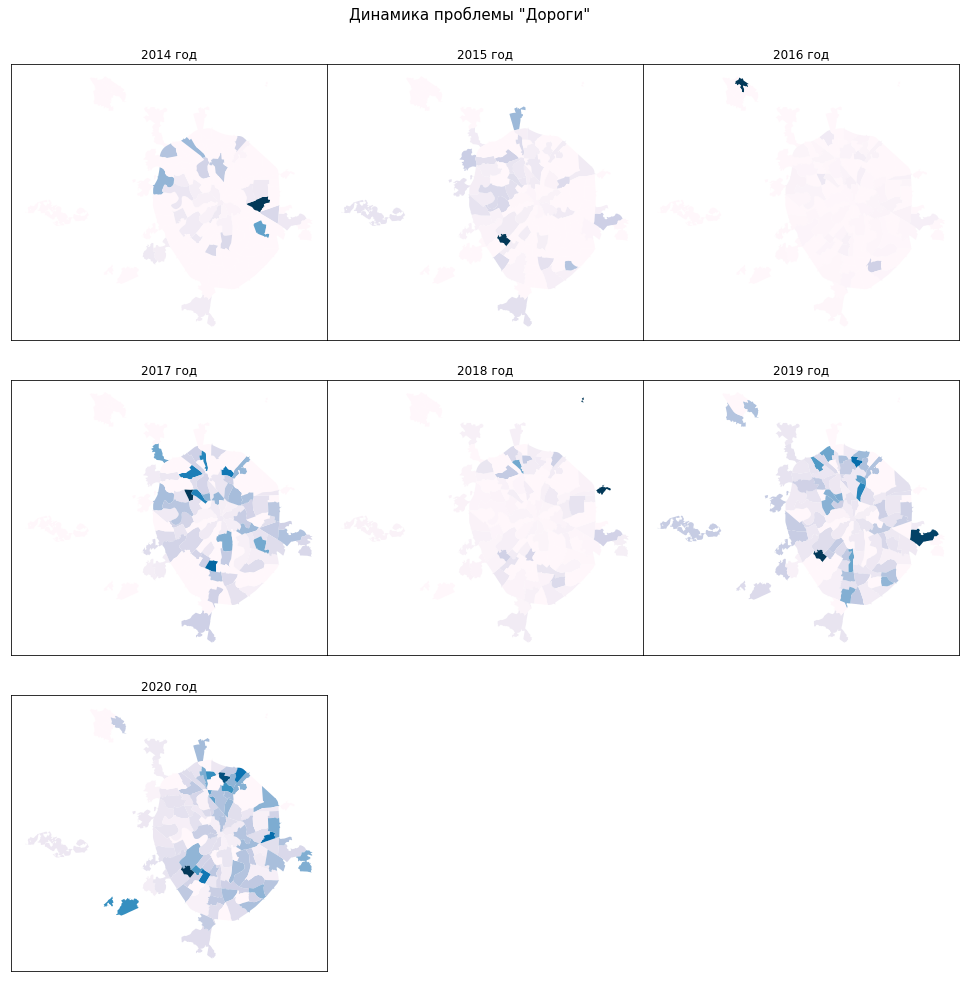

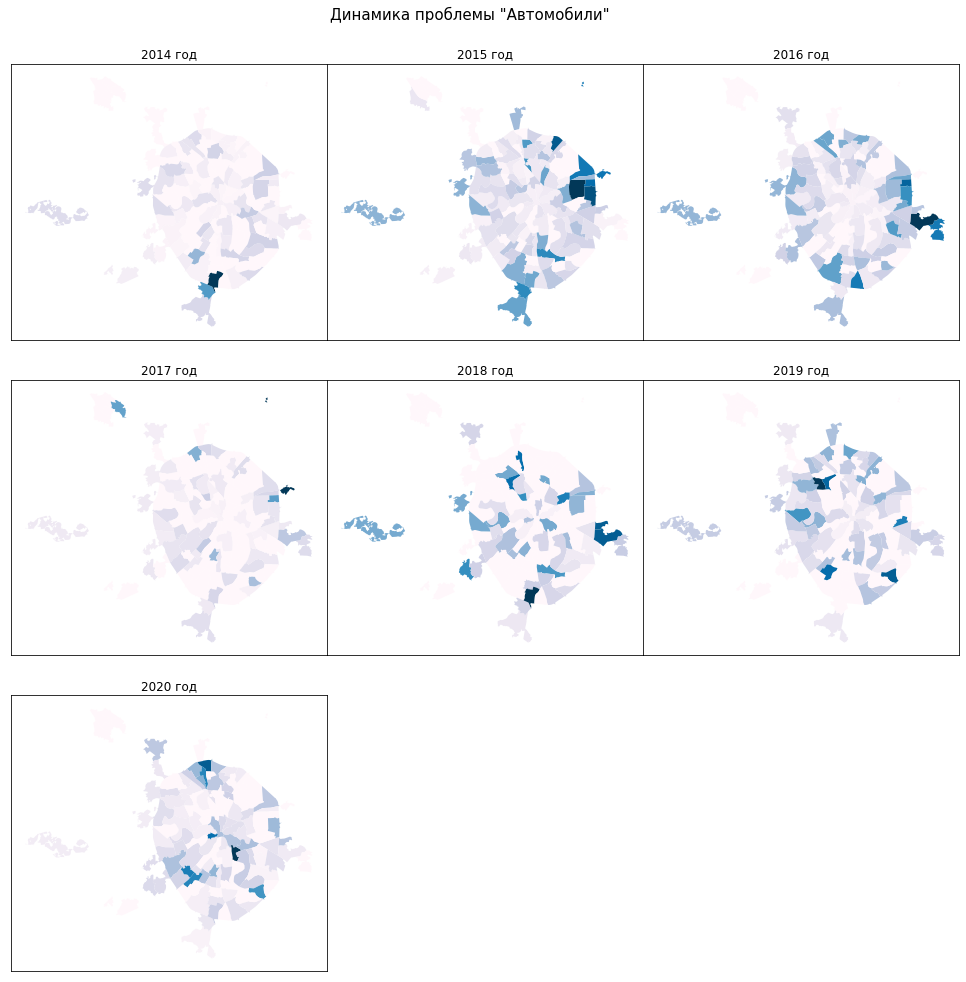

In [20]:
for num_topic, topic_name in enumerate(topics_prob.keys()):  # по всем топикам
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(17, 17))   
    plt.subplots_adjust(wspace=0, hspace=0.08)            # расстояние между axes
    plt.suptitle(f'Динамика проблемы "{topic_name}"', y=0.92, fontsize=15)
    num = 0
    for year, area_topic_prob in enumerate(area_topic_prob_list):             # по всем годам
        # Загрузка карты МО
        mo_gdf = gpd.read_file('mo-shape/mo.shp')
        # Сопоставление названий районов из текстов mos.ru и из карты районов
        mo_gdf['NAME_NORM'] = mo_gdf['NAME'].apply(lambda x: x.lower().replace('ё','е')) 
        mo_gdf['topic_importance'] = 0.0
        for j in mo_gdf.index:
            area_stemmed = mo_gdf.iloc[j]['NAME_NORM'] 
            for area in area_topic_prob.keys():
                if area_stemmed in area.lower():
                    try:
                        mo_gdf.loc[j,'topic_importance'] = float(area_topic_prob[area][num_topic])   
                        break
                    except Exception as e:
                        break
        mo_gdf = mo_gdf.loc[mo_gdf['TYPE_MO'] == 'Муниципальный округ']  # только муницип.округ печатаем  
        
        # Печатаем маленькие карты с темами проблемы
        mo_gdf.plot(ax=axes[num // 3, num % 3],
                    column = 'topic_importance', linewidth=1.5, cmap='PuBu', legend= False)
        axes[num // 3, num % 3].title.set_text(str(year+2014)+' год')   # год проблемы
    
        # Убираем маркировку осей от геопандаса
        axes[num // 3, num % 3].xaxis.set_major_locator(ticker.NullLocator())
        axes[num // 3, num % 3].yaxis.set_major_locator(ticker.NullLocator())
        num += 1
    plt.savefig(str(year+2014)+' год'+'.png')
    # удаляем пустые axes
    fig.delaxes(axes[2][1])
    fig.delaxes(axes[2][2])

## 2.3.2 Создаём gif-анимации с динамикой проблемы

***Для более наглядного и красивого представления сделаем анимации:***

In [21]:
for num_topic, topic_name in enumerate(topics_prob.keys()):  # по всем топикам
    num = 0
    for year, area_topic_prob in enumerate(area_topic_prob_list):             # по всем годам
        fig, axes = plt.subplots(figsize=(10, 10))
        # Загрузка карты МО
        mo_gdf = gpd.read_file('mo-shape/mo.shp')
        # Сопоставление названий районов из текстов mos.ru и из карты районов
        mo_gdf['NAME_NORM'] = mo_gdf['NAME'].apply(lambda x: x.lower().replace('ё','е')) 
        mo_gdf['topic_importance'] = 0.0
        for j in mo_gdf.index:
            area_stemmed = mo_gdf.iloc[j]['NAME_NORM'] 
            for area in area_topic_prob.keys():
                if area_stemmed in area.lower():
                    try:
                        mo_gdf.loc[j,'topic_importance'] = float(area_topic_prob[area][num_topic])   
                        break
                    except Exception as e:
                        break
        mo_gdf = mo_gdf.loc[mo_gdf['TYPE_MO'] == 'Муниципальный округ']  # только муницип.округ печатаем  

        # Печатаем маленькие карты с темами проблемы
        mo_gdf.plot(ax=axes,column = 'topic_importance', linewidth=1.5, cmap='PuBu', legend= False)
        axes.title.set_text(topic_name+'_'+str(year+2014)+' год')   # год проблемы
        # Убираем маркировку осей от геопандаса
        axes.xaxis.set_major_locator(ticker.NullLocator())
        axes.yaxis.set_major_locator(ticker.NullLocator())
        num += 1
        plt.savefig(str(num_topic)+'_'+str(year+2014)+' год'+'.png')  # сохраняем график
        plt.close(fig)    # закрываем график
        

In [22]:
from numpy import *
from pylab import *
import matplotlib.pyplot as plt 
import matplotlib.image as mgimg
from matplotlib import animation
%matplotlib notebook 
%matplotlib notebook

<IPython.core.display.Javascript object>


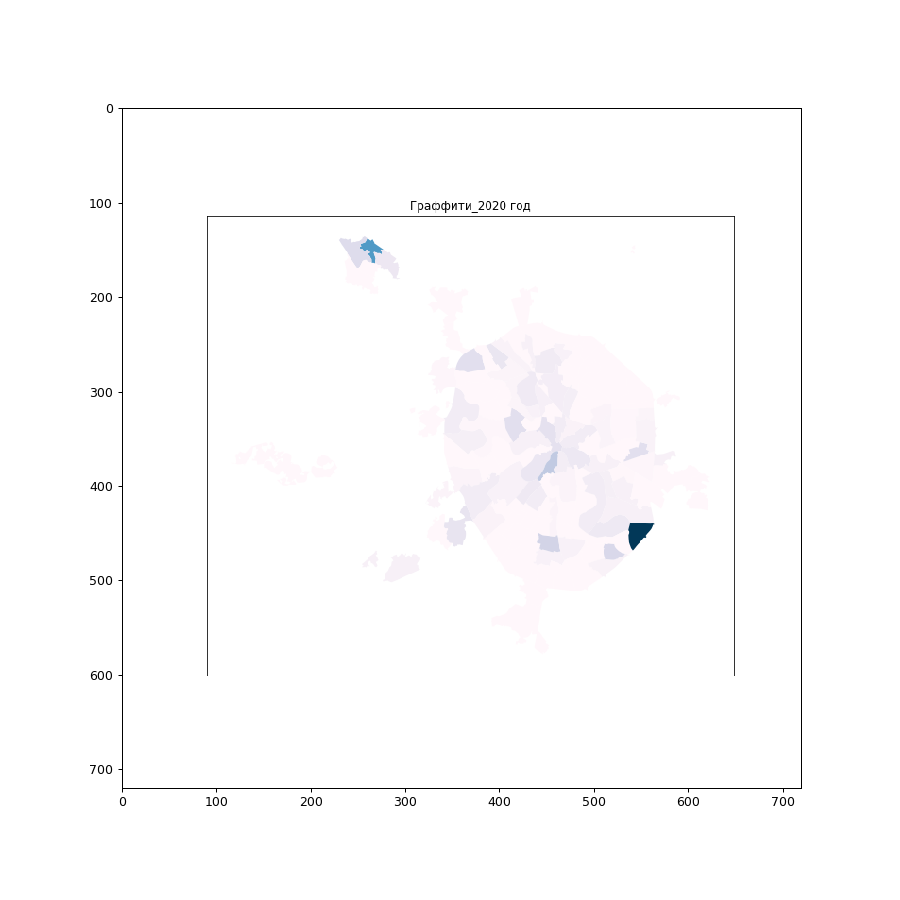

In [28]:
myimages = []
fig = plt.figure(figsize=(10, 10))
for topic in range(len(topics_prob)):
    for year in [2014, 2015,2016,2017,2018,2019,2020]:
        fname = str(topic)+'_'+str(year)+' год.png' #str(topic)+'_'+str(year)+' год.png'
        img = mgimg.imread(fname)
        imgplot = plt.imshow(img)
        myimages.append([imgplot])
    # Собираем анимацию из изображений:
    my_anim = animation.ArtistAnimation(fig, myimages, interval=1000, blit=True, repeat_delay=1000)
    # Сохраняем анимацию:
    f = r"animation.gif" 
    writergif = animation.PillowWriter(fps=30) 
    my_anim.save(f, writer=writergif)
    # Выводим анимацию:
    plt.show()

### PS: Нет идей как сохранить стейт гифки в ноутбуке :( Воспользуйтесь, пожалуйста, ссылкой на gif анимацию:
 https://disk.yandex.ru/i/H7izjIeU_iuhMg

***Видно, что такая глобальная проблема как "Мусор" только усиливается с каждым годом. Доля обращений по ней растёт во всех районах.***
***Доля незаконной рекламы начала снижаться, на лицо явное улучшение ситуации по сравнению с 2014м годом***

# 3 Выводы

***По данным обращений москвичей за 2013-2021 годы были установлены основные проблемы в районах. Показана динамика проблем. Выделены округа с наибольшим влиянием каждой проблемы.***